In [1]:
import tensorflow as tf
import numpy as np
import keras

class JSCC_Endcoder(keras.layers.Layer):
    def __init__(self, c, k):
        super(JSCC_Endcoder, self).__init__(name='JSCC_Encoder')
        self.k = k # k是信道带宽 k/n 是压缩比
        self.conv1 = keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding='same', name='conv1')
        self.prelu1 = keras.layers.PReLU(name='prelu1')
        self.conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', name='conv2')
        self.prelu2 = keras.layers.PReLU(name='prelu2')
        self.conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', name='conv3')
        self.prelu3 = keras.layers.PReLU(name='prelu3')
        self.conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', name='conv4')
        self.prelu4 = keras.layers.PReLU(name='prelu4')
        self.conv5 = keras.layers.Conv2D(filters=c, kernel_size=5, strides=1, padding='same', name='conv5')
        self.prelu5 = keras.layers.PReLU(name='prelu5')
    def Encoder_Norm(self, z):
        tmp = tf.math.sqrt(tf.reduce_sum(tf.math.conj(z) * z))
        tmp2 = tf.complex(tf.math.sqrt(self.k), tf.constant(0.0, dtype=tf.float32))
        return tmp2 * z / tmp # 假设功率P=1
    def call(self, input):
        x = input/255.0
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu2(x)
        x = self.conv4(x)
        x = self.prelu4(x)
        x = self.conv5(x)
        x = self.prelu5(x)
        x = tf.reshape(x, (2, -1))
        z = tf.complex(x[0], x[1])
        z = self.Encoder_Norm(z)
        return z
    

class JSCC_Decoder(keras.layers.Layer):
    def __init__(self, c):
        super(JSCC_Decoder, self).__init__(name='JSCC_Decoder')
        self.c = c
        self.trans_conv1 = keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same', name='trans_conv1')
        self.prelu6 = keras.layers.ReLU(name='prelu6')
        self.trans_conv2 = keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same', name='trans_conv2')
        self.prelu7 = keras.layers.ReLU(name='prelu7')
        self.trans_conv3 = keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same', name='trans_conv3')
        self.prelu8 = keras.layers.ReLU(name='prelu8')
        self.trans_conv4 = keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding='same', name='trans_conv4')
        self.prelu9 = keras.layers.ReLU(name='prelu9')
        self.trans_conv5 = keras.layers.Conv2DTranspose(filters=3, kernel_size=5, strides=2, padding='same', name='trans_conv5')
    def call(self, input):
        x = tf.concat([tf.math.real(input), tf.math.imag(input)], 0)
        x = tf.reshape(x, (-1, 8, 8, self.c))
        x = self.trans_conv1(x)
        x = self.prelu6(x)
        x = self.trans_conv2(x)
        x = self.prelu7(x)
        x = self.trans_conv3(x)
        x = self.prelu8(x)
        x = self.trans_conv4(x)
        x = self.prelu9(x)
        x = self.trans_conv5(x)
        x = keras.activations.sigmoid(x)
        x = x*255.0
        return x
        

class JSCC(keras.Model):
    def __init__(self, ratio, SNR):
        super(JSCC, self).__init__(name='JSCC')
        self.k = ratio * 6144.0
        self.c = int( self.k / 64.0)
        self.snr = SNR
        self.noi_pow = 1.0 / (10 ** (self.snr / 10))
        self.encoder = JSCC_Endcoder(self.c, self.k)
        self.decoder = JSCC_Decoder(self.c)
    def call(self, x):
        z = self.encoder(x)
        # self.noise = np.random.normal(0, np.sqrt(self.noi_pow), z.shape)
        real_noise = tf.random.normal(shape=tf.shape(z), mean=0.0, stddev=np.sqrt(self.noi_pow / 2))
        imag_noise = tf.random.normal(shape=tf.shape(z), mean=0.0, stddev=np.sqrt(self.noi_pow / 2))
        self.comp_noise = tf.complex(real_noise, imag_noise)
        z_hat = z + self.comp_noise
        x_hat = self.decoder(z_hat)
        return x_hat


2024-12-19 04:45:19.810102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734583519.827074  485283 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734583519.832087  485283 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 04:45:19.849164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
import keras
import JSCC_Model

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 증가 허용
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"사용 가능한 GPU 장치: {gpus}")
    except RuntimeError as e:
        print(f"GPU 설정 오류: {e}")
else:
    print("GPU를 찾을 수 없습니다. CPU에서 실행합니다.")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

ratio = [0.09]
train_SNR = [1, 4, 7, 13, 19]
test_SNR = [1, 4, 7, 10, 13, 16, 19 ,22, 25]
batch_size = 128
epochs = 50
lr = 1e-3
def train():
    #trainX shape:(50000, 32, 32, 3)  testX shape: (10000, 32, 32, 3)
    (trainX, _), (_, _) = keras.datasets.cifar10.load_data()
    trainX = trainX.astype('float32')
    for rt in ratio:
        for snr in train_SNR:
            print('***************ratio:{}, SNR:{}dB***************'.format(rt, snr))

            model = JSCC_Model.JSCC(rt, snr)
            # Build model
            input = keras.Input(shape=(32, 32, 3))
            output = model(input)
            model = keras.Model(input, output)
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.mean_squared_error)
            save_func = keras.callbacks.ModelCheckpoint(filepath=f'./checkpoint/JSCC_ratio{rt}_trainSNR{snr}.weights.h5', save_weights_only=True)
            model.fit(x=trainX, y=trainX, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[save_func])


if __name__ == '__main__':
    train()     



사용 가능한 GPU 장치: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
***************ratio:0.09, SNR:1dB***************


2024-12-19 04:53:19.631491: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 3236.3550
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2489.6887
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2451.8953
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2423.5398
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2412.1418
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2421.1665
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2406.2644
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2392.3083
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2381.7544
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2376.3186
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2379.0720
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2373.7004
Epoch 13/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2370.4734
Epoch 14/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2371.6528
Epoch 15/50
39

------------------------------loading model: ratio:0.09, trainSNR:1dB------------------------------


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'JSCC_Encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
W0000 00:00:1734585541.289905  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585541.290509  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2324.3643 - psnr: 14.9054

W0000 00:00:1734585542.385786  485387 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585542.385993  485387 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2323.8589 - psnr: 14.9044

  testing: testSNR:1dB, test_loss:2323.331298828125, test_psnr:14.896782875061035dB 



W0000 00:00:1734585544.727055  485384 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585544.727448  485384 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2056.6658 - psnr: 15.4472

W0000 00:00:1734585545.816781  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585545.816958  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2058.3271 - psnr: 15.4430

  testing: testSNR:4dB, test_loss:2067.6142578125, test_psnr:15.41923713684082dB 



W0000 00:00:1734585547.906313  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585547.906690  485383 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


58/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1979.6454 - psnr: 15.6262

W0000 00:00:1734585549.009283  485387 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585549.009499  485387 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1978.2413 - psnr: 15.6297

  testing: testSNR:7dB, test_loss:1976.20263671875, test_psnr:15.631701469421387dB 



W0000 00:00:1734585551.067760  485384 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585551.068106  485384 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1947.0277 - psnr: 15.7042

W0000 00:00:1734585552.180919  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585552.181102  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1946.2102 - psnr: 15.7051

  testing: testSNR:10dB, test_loss:1944.7750244140625, test_psnr:15.703166961669922dB 



W0000 00:00:1734585554.272635  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585554.273189  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1927.3497 - psnr: 15.7458

W0000 00:00:1734585555.360181  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734585555.360357  485388 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1926.7319 - psnr: 15.7473

  testing: testSNR:13dB, test_loss:1926.0262451171875, test_psnr:15.74798583984375dB 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1920.5233 - psnr: 15.7645

  testing: testSNR:16dB, test_loss:1919.6829833984375, test_psnr:15.761984825134277dB 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1916.6194 - psnr: 15.7726

  testing: testSNR:19dB, test_loss:1916.6795654296875, test_psnr:15.7678861618042dB 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1916.2760 - psnr: 15.7709

  testing: testSNR:22dB, test_loss:1915.350341796875, test_psnr:15.769257545471191dB 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1915.5204 - psnr: 15.7741

  testing: testSNR:25dB, test_loss:1914.881591796875, test_psnr:15.771251678466797dB 

------------------------------loading model: ratio:0.09, trainSNR:4dB------------------------------
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2578.9014 - psnr: 14.4185

  testing: test

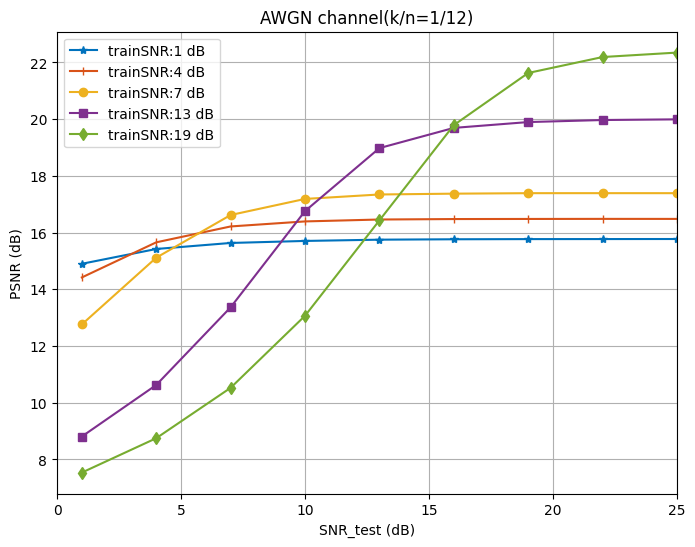

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

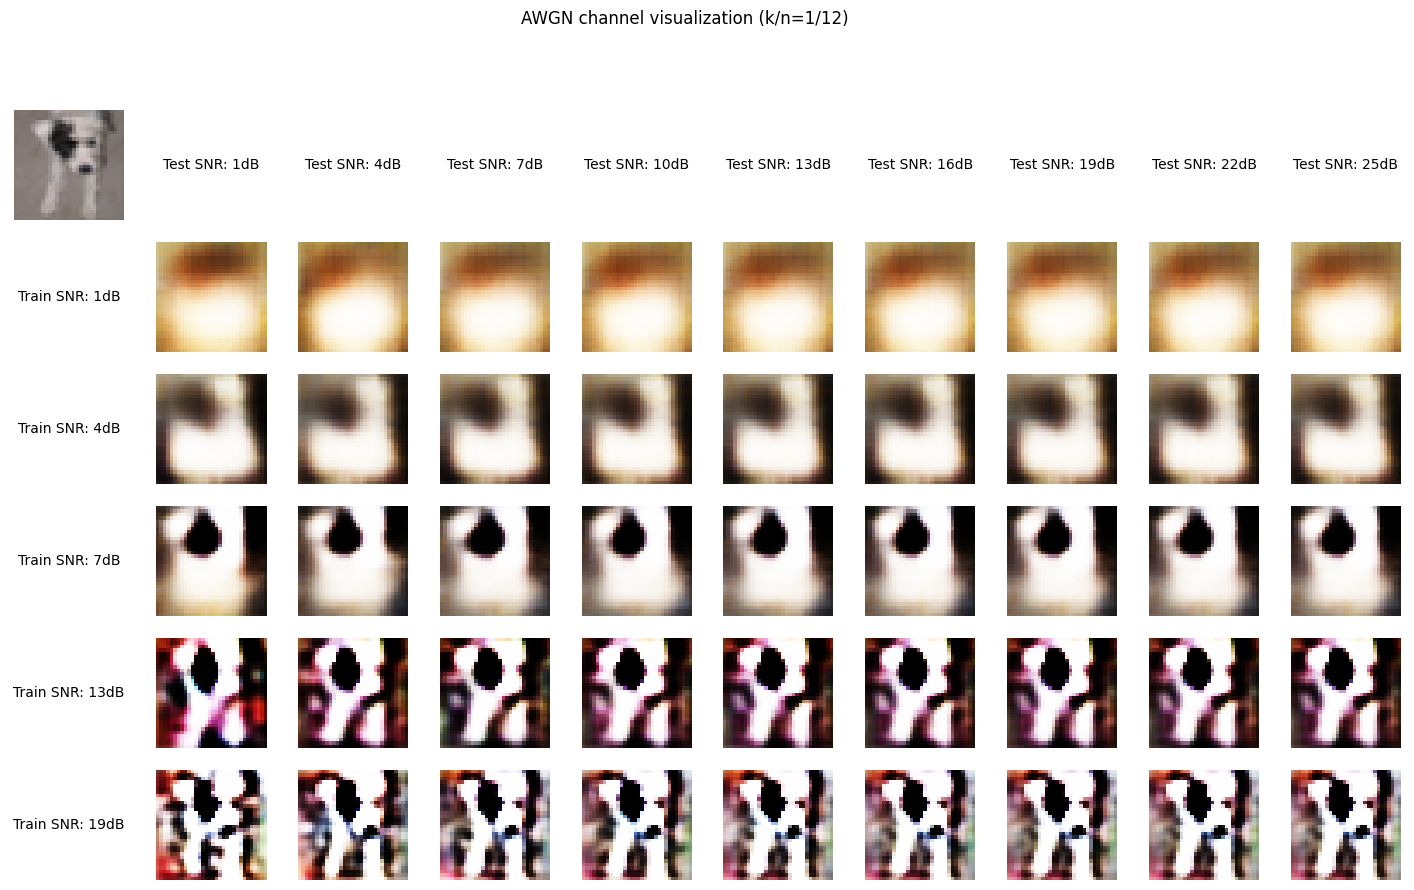

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
import JSCC_Model
import matplotlib.pyplot as plt
import numpy as np

ratio = [0.09]
train_SNR = [1, 4, 7, 13, 19]
test_SNR = [1, 4, 7, 10, 13, 16, 19 ,22, 25]
lr = 1e-3
test_batch_size = 128
markers = ['*', '|', 'o', 's', 'd']
colors = ['#0072bd', '#d95319', '#edb120', '#7e2f8e', '#77ac30']
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def eval(testX):
    testX = testX
    psnr_results = {tr_snr: [] for tr_snr in train_SNR}
    # 初始化为：{1: [], 4: [], 7: [], 13: [], 19: [] }
    for rt in ratio:
        for tr_snr in train_SNR:
            print('------------------------------loading model: ratio:{}, trainSNR:{}dB------------------------------'.format(rt, tr_snr))
            for te_snr in test_SNR:
                test_model = JSCC_Model.JSCC(rt, te_snr)
                # Build model
                input = keras.Input(shape=(32, 32, 3))
                output = test_model(input)
                test_model = keras.Model(input, output)
                test_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.mean_squared_error, metrics=[psnr])
                test_model.load_weights(f'./checkpoint/JSCC_ratio{rt}_trainSNR{tr_snr}.weights.h5')
                test_loss, test_psnr = test_model.evaluate(testX, testX, batch_size=test_batch_size, verbose=1)
                print('\n  testing: testSNR:{}dB, test_loss:{}, test_psnr:{}dB \n'.format(te_snr, test_loss, test_psnr))
                psnr_results[tr_snr].append(test_psnr)
    return psnr_results

def visualize(testX):
    # 随机选取一张原始图片
    random_index = np.random.randint(0, len(testX))
    original_image = testX[random_index]    
    # 创建 6x10 的子图布局
    fig, axes = plt.subplots(6, 10, figsize=(18, 10))
    # 标注第一行
    axes[0, 0].imshow(original_image.astype('uint8'))
    axes[0, 0].axis('off')
    for j in range(1, 10):
        axes[0, j].text(0.5, 0.5, f'Test SNR: {test_SNR[j - 1]}dB', horizontalalignment='center', verticalalignment='center')
        axes[0, j].axis('off')
    # 标注第一列
    for i in range(1, 6):
        axes[i, 0].text(0.5, 0.5, f'Train SNR: {train_SNR[i - 1]}dB', horizontalalignment='center', verticalalignment='center')
        axes[i, 0].axis('off')
    # 填充剩余的接收端恢复图
    for rt in ratio:
        for i, tr_snr in enumerate(train_SNR):
            for j, te_snr in enumerate(test_SNR):
                test_model = JSCC_Model.JSCC(rt, te_snr)
                # Build model
                input = keras.Input(shape=(32, 32, 3))
                output = test_model(input)
                test_model = keras.Model(input, output)
                test_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.mean_squared_error, metrics=[psnr])
                test_model.load_weights(f'./checkpoint/JSCC_ratio{rt}_trainSNR{tr_snr}.weights.h5')
                input_image = np.expand_dims(original_image, axis=0)
                restored_image = test_model.predict(input_image)[0]
                axes[i + 1, j + 1].imshow(restored_image.astype('uint8'))
                axes[i + 1, j + 1].axis('off')
    fig.suptitle('AWGN channel visualization (k/n=1/12)')
    plt.show()



if __name__ == '__main__':
    # 获取测试集
    (_, _), (testX, _) = keras.datasets.cifar10.load_data()
    testX = testX.astype('float32')
    # PSNR曲线
    psnr_results = eval(testX)
    plt.figure(figsize=(8, 6))
    for i, tr_snr in enumerate(train_SNR):
        plt.plot(test_SNR, psnr_results[tr_snr], marker=markers[i], color=colors[i], label=f"trainSNR:{tr_snr} dB")
    plt.xlabel('SNR_test (dB)')
    plt.ylabel('PSNR (dB)')
    plt.title('AWGN channel(k/n=1/12)')
    plt.legend()
    plt.xlim(0, 25)
    plt.grid()
    plt.show()
    # 图像可视化
    visualize(testX)
    

